In [1]:
import numpy as np
import torch
from networks import DQN
import rubiks2
import copy
import time
from tqdm import tqdm_notebook

In [2]:
c = 4.0
nu = 2.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class MonteCarloSearchTree(object):
    def __init__(self, env, network, max_time, n_actions):
        self.env = env
        self.network = network
        self.max_time = max_time
        state = env.get_observation()
        prior_probabilities = network.policy(torch.tensor(state, dtype=torch.float32, device=device)).detach().cpu().numpy()
        self.root = State(prior_probabilities=prior_probabilities)
        
    def search(self):
        t_0 = time.time()
        expansions = 0
        
        while time.time() - t_0 < self.max_time:
            action_seq = []
            
            current_node = self.root
            current_env = copy.deepcopy(self.env)
            
            current_action = None
            while not current_node.is_leaf():
                current_node, current_action = current_node.select() 
                current_env.step(current_action)
                action_seq.append(current_action)
                
            if current_env.solved():
#                 print("Solved in: ", expansions, " expansions")
#                 print(action_seq)
                return 1.0
                
            current_node.expand(current_env)
            expansions += 1
            
            state = env.get_observation()
            value = network.value(torch.tensor(state, dtype=torch.float32, device=device)).detach().cpu().numpy()
            
            while current_node is not None and current_action is not None:
                current_node.update(current_action, value)
                current_node = current_node.parent
        return 0.0
                
        
class State(object):
    def __init__(self, parent=None, prior_probabilities=None):
        self.N = np.zeros(6)
        self.W = np.zeros(6)
        self.L = np.zeros(6)
        self.P = prior_probabilities
        self.parent = parent
        self.children = []
        
    def is_leaf(self):
        return len(self.children)==0
    
    def select(self):
        highest = 0.0
        highest_action = 0
        
        for action in range(6):
            uct = c*self.P[action]*(np.sqrt(np.sum(self.N))/(1+self.N[action])) + self.W[action] - self.L[action]
            if uct>highest:
                highest = uct
                highest_action = action
                
        return self.children[highest_action], highest_action
    
    def expand(self, env):
        for action in range(6):
            tmp_env = copy.deepcopy(env)
            tmp_env.step(action)
            state = tmp_env.get_observation()
            prior_probabilities = network.policy(torch.tensor(state, dtype=torch.float32, device=device)).detach().cpu().numpy()
            self.children.append(State(self, prior_probabilities))
            
    def update(self, action, value):
        self.W[action] = max(self.W[action], value)
        self.N[action] += 1
        self.L[action] -= nu

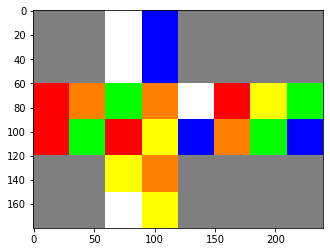

KeyboardInterrupt: 

In [4]:
env = rubiks2.RubiksEnv2(2, unsolved_reward = -1.0)
network = torch.load('./models/Same/model.pt')
env.reset(9)
env.render()
MCTS = MonteCarloSearchTree(env, network, 60.0, 6)
MCTS.search()

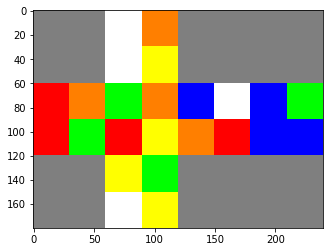

In [5]:
env.step(1)
env.render()

In [9]:
solve_rate = np.zeros(14)
counts = np.zeros(14)
for i in range(14):
    hashes = []

    for sequence in tqdm_notebook(superflip_set):
        env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0)
        
        hashed_sequence = hash(str(sequence[:i+1]))
        
        if hashed_sequence in hashes:
            break
        
        counts[i] += 1
        
        for j in range(i + 1):
            env.step(sequence[j])
            
        MCTS = MonteCarloSearchTree(env, network, 5.0, 6)
        solve_rate[i] += MCTS.search()
        
        hashes.append(hashed_sequence)
    
print(np.divide(solve_rate, counts))

[1.         1.         1.         1.         1.         0.81609195
 0.60869565 0.29192547 0.11180124 0.02484472 0.         0.00621118
 0.00621118 0.        ]


In [8]:
superflip_set = [[4,0,5,1,5,4,5,5,1,3,2,1,3,3],
[0,5,1,1,0,0,1,5,0,2,2,4,4,5],
[1,2,2,3,3,5,0,4,0,2,4,3,5,0],
[1,0,5,0,4,3,3,1,3,1,0,2,3,2],
[5,0,5,1,5,1,5,1,5,1,5,3,1,5],
[3,5,3,2,4,2,4,5,1,0,4,3,5,0],
[2,4,2,0,0,2,4,5,3,1,0,0,4,4],
[5,0,5,4,3,2,3,4,3,2,4,2,2,1],
[2,0,4,0,4,0,4,0,4,5,3,5,4,5],
[2,4,2,4,3,2,2,1,3,5,4,4,2,3],
[4,4,0,4,0,5,4,5,0,0,1,3,1,2],
[0,4,0,5,1,1,0,2,2,3,2,3,5,5],
[0,1,0,4,2,4,2,4,0,2,4,5,4,3],
[2,3,2,2,1,5,1,5,3,5,1,5,5,4],
[4,0,5,4,0,4,3,2,3,5,1,0,5,0],
[2,3,1,2,1,5,3,2,3,1,2,1,2,2],
[5,4,0,5,3,1,2,4,2,1,5,1,0,2],
[2,4,0,1,3,4,0,0,2,2,4,0,5,4],
[5,1,2,3,4,3,5,3,2,4,2,0,2,0],
[1,2,0,4,2,3,1,3,1,0,4,5,0,1],
[4,2,1,5,0,2,3,5,4,2,3,1,5,3],
[2,3,4,5,1,5,0,4,2,3,1,2,1,3],
[0,5,1,3,2,4,0,0,4,0,4,0,5,0],
[5,1,2,3,5,1,3,4,2,4,5,5,0,2],
[0,4,3,5,1,0,5,0,2,3,4,4,3,1],
[3,3,4,2,4,5,1,3,3,5,0,2,0,0],
[5,3,1,3,5,1,0,0,1,0,1,5,4,4],
[2,0,1,5,1,3,1,2,4,3,2,4,0,2],
[1,0,4,3,5,3,5,1,5,0,4,3,2,1],
[3,1,0,2,2,0,5,3,1,3,4,5,1,3],
[1,3,5,4,0,2,2,3,1,3,4,0,2,3],
[5,3,1,1,3,2,1,5,0,5,1,1,2,3],
[4,3,2,1,3,5,1,5,4,4,2,4,3,4],
[4,4,3,5,0,5,5,3,1,3,2,4,5,1],
[4,4,5,0,5,3,2,1,1,3,1,0,1,1],
[5,1,2,3,2,1,2,3,3,4,3,2,4,4],
[3,3,1,2,4,0,4,2,4,3,3,4,2,2],
[3,5,0,5,5,3,1,3,2,3,2,1,5,4],
[3,4,2,2,4,5,1,5,0,5,1,2,4,5],
[4,2,4,2,2,1,0,4,0,1,2,4,5,4],
[4,0,4,0,5,1,2,1,3,2,1,0,5,3],
[1,2,2,3,3,4,0,2,1,0,4,0,5,0],
[2,3,3,5,1,3,2,3,1,5,4,4,2,2],
[1,2,2,4,2,4,0,4,3,3,5,5,4,0],
[4,0,4,4,5,4,4,2,4,0,5,5,0,4],
[5,1,3,2,1,3,2,1,2,1,0,5,4,3],
[4,4,2,0,1,1,5,3,1,3,2,0,4,5],
[0,1,5,3,2,1,5,3,2,4,0,2,4,2],
[1,3,2,3,5,0,1,5,0,1,3,4,0,0],
[1,2,1,3,1,5,1,3,1,5,4,3,5,5],
[3,1,3,4,2,3,4,3,4,4,0,2,3,1],
[5,1,2,2,1,5,0,5,5,3,5,5,1,3],
[5,3,2,4,0,5,4,3,2,4,5,3,2,3],
[1,2,1,3,2,4,0,4,2,0,1,2,3,5],
[3,5,5,3,5,0,5,4,2,2,4,2,3,2],
[4,5,1,5,4,2,1,1,3,5,1,2,3,2],
[3,5,1,3,3,1,2,3,2,3,1,2,4,2],
[2,0,1,3,2,3,1,3,2,4,5,0,4,4],
[1,2,4,2,0,0,4,3,1,3,2,2,0,0],
[2,3,3,5,4,0,4,0,4,5,4,5,4,0],
[2,1,3,2,2,3,1,3,2,0,4,3,3,2],
[4,4,5,4,2,2,4,0,5,0,1,3,2,3],
[3,2,4,4,3,5,0,4,0,4,5,5,1,0],
[3,4,2,4,2,4,2,4,0,2,0,2,0,1],
[4,5,3,4,0,4,5,0,1,3,1,2,1,2],
[3,5,5,1,3,2,4,3,3,4,3,2,1,1],
[3,4,4,3,1,2,3,1,5,0,5,4,5,0],
[0,2,0,1,1,5,0,1,3,1,3,5,1,5],
[3,1,5,1,2,0,5,3,1,5,5,4,2,4],
[2,4,4,5,3,1,3,5,1,2,4,3,3,4],
[3,1,3,4,3,5,1,5,0,5,4,4,0,4],
[2,3,1,5,3,1,5,1,2,1,5,5,1,2],
[3,3,4,0,1,5,3,2,3,3,2,3,1,3],
[1,5,3,1,2,0,2,0,4,0,5,3,5,4],
[0,1,1,5,0,4,5,0,2,4,5,1,5,4],
[3,2,4,2,1,5,0,0,1,2,4,5,4,0],
[0,4,0,5,0,4,2,4,2,2,4,2,3,2],
[5,0,5,5,4,3,5,1,5,1,5,3,1,5],
[0,5,4,5,0,4,0,4,0,1,5,3,3,2],
[5,5,3,2,3,1,0,1,5,1,1,3,5,5],
[0,5,1,0,5,3,3,5,1,2,0,5,5,4],
[0,4,5,5,1,5,0,5,3,1,5,4,3,1],
[5,1,0,4,2,2,0,1,2,2,1,5,1,1],
[4,4,0,2,3,1,5,1,3,4,4,3,1,1],
[0,5,1,5,1,2,2,0,0,1,1,2,4,2],
[2,0,2,2,3,1,0,4,0,2,2,3,1,2],
[4,0,2,3,1,5,3,1,5,0,2,4,0,4],
[1,3,5,4,0,2,4,2,4,3,5,4,4,0],
[5,4,3,5,1,5,1,1,2,4,2,0,4,3],
[1,5,4,0,5,4,3,1,2,3,4,4,5,3],
[0,2,3,2,0,2,3,1,3,1,5,1,0,0],
[5,4,3,2,3,2,0,5,0,4,4,2,0,2],
[2,1,5,1,2,4,4,0,2,1,2,4,3,3],
[2,3,2,2,1,0,1,3,5,1,2,1,1,2],
[5,0,4,3,1,3,4,0,1,5,1,0,1,3],
[5,5,0,0,2,4,2,1,5,0,4,3,4,4],
[1,0,5,0,1,2,4,5,1,3,5,0,2,3],
[4,4,2,0,5,1,5,0,5,1,1,5,3,3],
[0,2,4,5,5,4,5,3,1,3,3,2,3,1],
[4,0,5,5,1,3,5,1,3,1,3,5,0,4],
[0,2,2,4,2,4,3,2,2,3,3,1,0,2],
[5,1,3,1,2,0,4,2,2,0,4,4,3,1],
[1,2,1,1,0,5,0,5,1,2,0,5,3,5],
[3,1,5,1,0,4,3,1,0,2,4,5,5,0],
[5,5,1,0,4,2,3,2,4,5,5,1,2,2],
[2,3,2,3,1,5,0,1,2,3,3,5,1,3],
[4,2,4,4,0,4,5,0,5,0,4,3,1,3],
[1,3,1,3,4,0,2,2,0,1,0,4,2,2],
[3,1,5,1,5,0,4,3,4,5,5,1,3,1],
[5,4,0,1,5,0,2,4,0,5,1,1,2,3],
[2,1,0,4,5,0,4,2,3,2,4,2,1,0],
[0,4,2,1,3,2,4,0,2,1,5,5,3,1],
[0,5,3,4,4,3,2,0,5,0,4,5,4,3],
[2,3,2,3,5,0,1,5,4,5,0,5,5,4],
[4,0,5,5,0,2,0,4,2,0,4,5,0,4],
[4,0,4,5,1,5,0,1,2,3,2,1,1,3],
[3,4,4,2,1,5,1,3,2,4,4,5,1,1],
[0,5,3,3,2,0,2,4,0,4,0,5,1,2],
[2,1,5,1,3,1,0,5,0,2,2,3,3,1],
[0,4,5,5,0,4,3,1,3,2,3,2,1,3],
[1,0,0,5,0,5,1,3,3,1,2,3,2,2],
[4,5,1,3,4,2,0,5,4,2,3,5,5,1],
[3,2,1,5,3,2,3,4,5,4,4,2,1,3],
[3,5,5,1,3,5,3,2,2,1,3,5,1,2],
[3,4,2,1,1,2,3,4,3,5,3,5,5,1],
[0,4,0,5,0,4,3,2,3,1,1,0,2,1],
[2,1,5,0,4,3,4,2,3,3,1,0,0,1],
[4,4,3,2,4,2,0,2,0,0,5,0,5,4],
[2,0,4,0,4,5,4,2,0,0,2,4,5,0],
[1,2,3,1,3,2,4,4,5,3,4,3,5,0],
[4,2,3,5,3,2,3,5,3,1,2,3,5,0],
[3,4,0,4,2,3,1,0,5,4,4,0,2,2],
[4,2,2,4,0,2,3,1,5,1,1,0,4,4],
[1,2,0,2,0,4,0,5,3,1,3,4,0,4],
[0,1,3,1,1,5,0,1,3,2,4,4,0,5],
[2,3,1,3,1,2,3,4,4,2,4,4,3,1],
[4,0,5,5,4,5,1,5,0,4,5,3,1,0],
[2,4,2,3,2,0,5,4,4,0,5,5,4,0],
[5,3,1,5,0,2,1,3,4,2,1,5,1,3],
[4,4,0,5,1,3,1,2,1,5,0,1,0,5],
[5,1,1,5,1,2,3,1,3,5,5,1,0,0],
[1,5,3,2,3,5,0,1,2,2,1,5,1,3],
[5,4,0,0,2,1,0,4,2,3,1,3,1,2],
[0,1,1,0,4,3,5,0,4,5,3,1,5,3],
[5,4,2,4,2,3,2,1,0,0,4,5,0,0],
[4,0,5,0,5,0,2,0,4,3,2,3,4,5],
[2,0,5,0,4,4,5,4,2,4,0,0,4,4],
[0,4,2,3,1,3,4,0,2,2,4,2,2,0],
[2,3,4,5,0,1,2,3,2,1,3,5,3,3],
[4,2,3,4,3,1,1,3,4,3,4,2,0,4],
[0,4,3,2,4,5,5,1,3,2,1,3,5,5],
[5,1,0,1,0,5,1,5,4,2,2,4,3,4],
[5,5,4,5,4,0,1,5,3,2,1,3,4,4],
[4,4,0,5,3,1,5,0,1,3,3,4,2,4],
[5,3,2,1,5,1,3,4,5,0,4,4,5,5],
[5,0,5,0,5,1,5,5,0,4,3,4,0,2],
[0,2,3,4,5,1,5,1,1,3,2,0,4,0],
[5,3,2,3,5,0,1,5,4,2,4,3,3,2],
[2,4,4,0,4,0,4,2,3,1,2,0,4,5],
[5,5,1,3,5,4,3,2,1,5,4,2,3,4],
[5,5,4,2,3,1,5,1,2,0,4,3,4,5],
[4,2,3,5,3,2,3,5,3,1,2,3,5,3],
[1,3,2,4,5,3,3,1,0,2,3,1,0,2],
[3,2,4,4,0,5,3,2,0,2,2,1,1,3],
[1,0,4,2,1,3,2,2,3,4,5,1,5,5],
[3,1,0,4,2,2,4,3,4,0,4,2,2,4],
[2,3,1,2,2,4,2,1,5,0,5,1,5,3],
[1,5,0,5,3,4,5,4,2,3,5,1,3,2],
[0,4,0,4,0,4,5,0,4,5,0,1,2,2],
[3,2,4,4,3,4,2,4,5,1,0,0,5,5],
[1,3,4,4,5,1,3,5,0,4,2,3,5,3],
[3,3,1,5,1,5,1,2,1,3,5,0,5,3],
[3,1,0,4,2,3,2,0,2,4,4,3,2,4],
[4,2,3,1,1,2,0,2,2,3,1,3,1,5],
[5,3,1,5,1,5,3,4,4,2,4,5,4,2],
[5,1,2,3,1,1,2,0,5,5,0,5,1,1],
[2,4,0,1,3,1,3,2,0,1,1,0,2,2],
[4,0,5,5,0,2,2,1,0,1,0,4,5,5],
[3,2,1,5,0,5,0,1,5,1,2,0,4,0],
[2,4,2,3,5,0,2,2,1,5,3,2,3,1],
[3,3,5,1,2,3,3,5,1,3,4,2,2,3],
[5,1,3,4,3,5,3,1,2,4,4,0,2,4],
[4,4,3,4,5,0,2,3,2,3,4,2,1,2],
[2,3,3,2,3,3,1,5,4,5,0,4,0,1],
[4,2,3,1,3,5,4,0,1,3,4,2,1,1],
[5,0,2,4,5,3,3,1,3,5,4,0,1,1],
[3,4,0,1,5,0,0,1,2,4,0,4,4,3],
[2,3,5,4,2,4,0,2,0,5,1,1,5,5],
[4,2,3,5,1,3,2,1,5,4,3,1,5,3],
[5,1,3,5,4,2,3,4,5,1,2,3,4,0],
[5,5,3,2,3,4,0,4,3,1,0,5,4,5],
[3,5,0,4,3,5,5,1,3,2,0,2,4,2],
[3,1,2,0,5,1,0,2,3,5,1,0,4,5],
[2,0,5,3,3,5,1,3,4,2,3,5,3,4],
[1,0,5,1,2,3,1,1,2,4,4,2,2,0],
[1,5,1,5,1,3,5,0,4,3,1,5,4,2],
[0,1,3,3,2,3,4,5,1,5,1,0,0,4],
[1,3,4,0,5,3,2,0,1,3,2,4,0,2],
[3,2,3,2,2,1,2,1,3,1,3,1,2,4],
[4,2,4,0,2,0,4,3,5,0,4,0,4,5],
[3,1,2,2,4,0,4,2,3,1,0,1,5,1],
[0,1,1,5,1,3,1,5,4,3,1,5,3,3],
[3,3,2,2,3,1,2,0,4,2,3,4,3,1],
[4,4,0,4,3,1,2,1,5,5,4,2,0,2],
[2,4,0,0,1,2,4,2,3,1,2,4,4,3],
[3,1,0,4,2,2,4,3,4,0,5,5,0,5],
[5,3,1,1,0,5,1,2,1,0,2,2,1,2],
[5,3,4,0,4,3,3,5,1,2,3,2,4,3],
[2,3,5,1,3,3,5,4,2,2,4,2,0,0],
[0,5,1,3,2,3,2,4,3,1,1,2,3,4],
[4,2,4,4,3,5,0,4,3,2,3,3,1,1],
[2,4,0,0,4,3,3,5,3,5,4,0,5,5],
[2,3,2,2,1,5,4,2,3,4,5,3,2,4],
[2,1,3,1,1,0,4,2,3,1,2,0,5,1],
[0,5,0,5,1,3,2,4,5,4,2,1,3,5],
[5,1,0,4,3,2,4,2,4,5,5,3,2,4],
[5,0,4,0,4,5,0,2,0,4,0,5,0,1],
[2,3,2,4,3,1,5,4,2,3,5,0,4,2],
[1,5,0,5,1,2,3,2,4,0,0,4,3,4],
[2,3,4,0,2,2,1,3,2,4,2,4,2,4],
[2,0,1,5,0,0,4,2,4,3,2,0,0,1],
[5,5,3,1,3,3,5,0,2,3,2,4,0,4],
[0,2,2,4,2,3,2,4,4,2,1,3,4,4],
[2,0,4,2,2,1,3,2,3,2,4,3,1,0],
[3,1,2,3,5,1,5,5,3,3,1,0,4,0],
[3,5,0,1,1,3,2,3,1,5,0,2,0,4],
[4,5,1,3,2,2,1,1,3,1,5,0,5,3],
[5,0,4,2,3,2,4,3,2,3,5,0,5,4],
[3,2,1,2,4,2,1,2,4,4,0,2,4,3],
[3,5,5,4,4,2,3,2,0,5,4,4,5,0],
[1,0,2,4,2,0,0,5,0,5,1,0,4,2],
[4,2,4,3,2,4,2,1,0,5,1,2,2,3],
[2,1,0,0,5,0,1,3,2,3,1,1,2,0],
[4,2,2,1,2,4,2,3,2,0,2,1,2,4],
[2,3,5,4,4,0,1,2,1,5,0,0,1,1],
[5,5,1,0,2,3,1,5,5,4,0,5,3,4],
[3,1,5,4,2,3,2,0,2,4,0,0,4,0],
[3,2,3,4,0,1,3,4,5,0,1,1,5,1],
[5,3,1,2,0,4,0,2,4,2,0,1,2,2],
[2,4,3,4,2,4,0,4,2,3,1,0,1,5],
[3,3,1,2,2,1,0,5,1,3,1,0,5,0],
[4,2,1,5,0,4,4,2,2,0,5,3,2,4],
[0,5,1,2,2,1,0,1,3,5,0,4,0,1],
[2,4,5,4,0,1,1,5,3,1,3,2,3,2],
[5,0,4,0,4,5,4,2,1,0,4,0,4,4],
[4,4,5,4,2,2,0,1,3,1,3,5,1,2],
[2,1,3,5,0,2,3,4,5,1,3,4,5,1],
[0,2,3,5,5,3,1,3,4,0,5,3,5,4],
[4,3,1,3,2,4,0,4,2,4,5,0,1,1],
[0,5,3,4,4,2,4,2,3,5,1,1,0,1],
[3,4,4,2,4,0,1,0,0,1,0,0,2,1],
[4,3,2,1,5,3,1,5,3,5,3,4,0,1],
[2,4,2,3,1,0,2,3,3,4,3,4,5,1],
[2,4,2,0,1,5,1,3,5,1,2,3,3,5],
[3,4,0,4,4,0,4,2,0,1,1,0,5,5],
[5,5,1,0,5,0,4,3,1,3,2,2,3,3],
[3,1,5,3,1,5,1,3,5,1,5,1,1,2],
[4,2,3,1,5,5,0,5,0,2,1,5,1,1],
[5,4,2,1,5,0,4,0,5,4,5,5,4,5],
[0,5,4,2,0,4,2,1,2,0,0,5,4,2],
[5,0,0,2,2,1,5,4,2,4,4,3,3,4],
[3,1,0,5,1,5,4,2,4,5,4,3,5,1],
[4,4,5,0,4,5,3,3,5,1,0,4,2,1],
[4,2,3,4,0,2,4,2,2,4,0,5,4,4],
[2,4,5,4,0,1,5,1,5,3,5,0,0,1],
[3,4,2,4,0,1,2,4,4,3,1,0,1,2],
[5,1,2,2,3,5,0,5,4,0,5,5,4,4],
[3,2,3,1,2,2,4,5,3,3,1,3,1,5],
[3,4,3,2,4,0,4,0,1,2,1,5,0,5],
[1,5,4,3,1,5,3,2,0,5,0,2,3,1],
[4,5,1,3,5,0,4,2,3,2,0,2,4,4],
[1,3,2,4,0,2,3,5,4,2,3,2,4,4],
[2,0,1,1,5,0,2,3,2,4,2,2,0,2],
[3,1,5,0,4,2,4,2,1,0,4,2,1,1],
[3,4,2,4,0,5,3,1,1,3,1,2,4,2],
[4,4,5,3,5,1,2,3,1,2,2,4,2,1]]